# Demo of the framework in ANNs

In this notebook, we will reproduce Figure 2 of the paper.

A generalized ANN $f:\mathcal{X}\rightarrow\mathbb{C}$ has an integral representation of the form
$$
f(x) = \int_\Omega h(\omega)\sigma(x;\omega)dV(\omega).
$$

If we represent a holomorphic $h:\Omega\rightarrow\mathbb{C}$ with its power series representation $h(\omega)=\sum_{i=0}^\infty a_i\varphi_i(\omega)$, we would have
$$
f(x) = \sum_{i=0}^\infty a_i \int_\Omega \varphi_i(\omega)\sigma(x;\omega)dV(\omega)=\sum_{i=0}^\infty a_i \psi_i(x).
$$

We call $\psi_i(x)$ a projected feature of the activation function. Thus, training generalized ANNs would reduce to the case of polynomials if we compute $\psi(x)$ beforehand.

To reproduce Figure 2, we first have to generate the training samples,
$$
S=\big\{(0,-1),(1,+1)\big\}.
$$

In [1]:
import numpy as np

D = 30
N = 2

x = np.linspace(0, 1, N)
y = -np.sign(np.cos(np.pi * x))

Then we will compute the orthonormal and harmonic projected features for a holomorphic $h$,
$$
\psi_n(x)=\int_\mathbb{D}\frac{\omega^n}{\sqrt{\gamma_n}} \cdot \mathrm{ReLU}(wx + b)dwdb, \quad \omega=w+ib,
$$
in which $\gamma_n$ is the appropriate normalization constant for the orthonormal and the harmonic features. The integral could be computed with the aid of a computer algebra system.

In [2]:
def psi(_x, _n, _t=0):
    """
    When _t == 0 the function computes the projections of orthonormal features, and when _t == 1 it computes the projections of harmonic features
    """
    gamma = lambda i: _t * np.pi / (i + 1) + (1 - _t) * i * np.pi if i > 0 else 1
    a = 4/3 * (1 / (_n + 1) * (_n + 3))
    c = a / np.sqrt(gamma(_n))
    return c * (1 + 1j*_x) * np.exp(1j * (_n+1) * np.arctan(_x))

Next, we will apply the learning rules to the problem

In [3]:
import cvxpy as cp

Wr = cp.Variable(D+1)
Wi = cp.Variable(D+1)
ksi = cp.Variable(N)
Vr = cp.Parameter((N, D+1))
Vi = cp.Parameter((N, D+1))

constraints = [
  ksi >= 0,
  cp.multiply(Vr @ Wr - Vi @ Wi, y) >= 1 - ksi,
  Vr @ Wi + Vi @ Wr <= ksi,
  Vr @ Wi + Vi @ Wr >= -ksi
]

loss = cp.norm(Wr) + cp.norm(Wi) + cp.sum(ksi)
prob = cp.Problem(cp.Minimize(loss), constraints)

In [7]:
def vander(_x, _D, _t=0):
  V = np.zeros((len(_x), _D+1))
  for d in range(_D+1):
    V[:, d] = psi(_x, d, _t)
  return V

In [9]:
Phi = vander(x, D, 0)
Vr.value, Vi.value = np.real(Phi), np.imag(Phi)
prob.solve()

w_harm = Wr.value + 1j * Wi.value

Phi = vander(x, D, 1)
Vr.value, Vi.value = np.real(Phi), np.imag(Phi)
prob.solve()

w_orth = Wr.value + 1j * Wi.value

<ipython-input-7-a131e0aa9ffd>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = psi(_x, d, _t)


<ipython-input-7-a131e0aa9ffd>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = psi(_x, d, _t)
<ipython-input-7-a131e0aa9ffd>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = psi(_x, d, _t)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


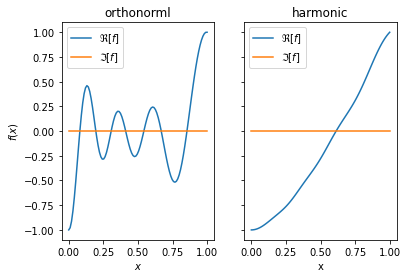

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharey='all')

xx = np.linspace(0, 1, 100)

z = vander(xx, D, 0) @ w_harm
re, = ax[1].plot(xx, np.real(z), label='$\Re[f]$')
im, = ax[1].plot(xx, np.imag(z), label='$\Im[f]$')
ax[1].set_title('harmonic')
ax[1].set_xlabel('x')
ax[1].legend()

z = vander(xx, D, 1) @ w_orth
ax[0].plot(xx, np.real(z), label='$\Re[f]$')
ax[0].plot(xx, np.imag(z), label='$\Im[f]$')
ax[0].set_title('orthonorml')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$f(x)$')
ax[0].legend()

fig.savefig('ann_real.eps')

Similar to the the case of complex polynomials, we can visualize $h$ on the unit disk given that training the generalized ANN is the same as computing the coeficients of the power series representation of $h$.

<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)


Text(0.5, 0, '$\\Re[\\omega]$')

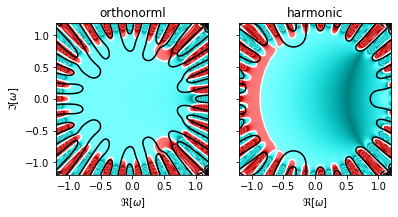

In [18]:
from dcolor import DColor

def poly(_x, _D, _t=0):
  V = np.zeros((len(_x), _D+1))
  for d in range(_D+1):
    gamma = _t * np.pi / (d + 1) + (1 - _t) * d * np.pi if d > 0 else 1
    V[:, d] = _x ** d / np.sqrt(gamma)
  return V

def clp_harm(Z):
    z = Z.flatten()
    phi = poly(z, D, 0)
    out = phi @ w_harm

    return out.reshape(Z.shape)

def clp_orth(Z):
    z = Z.flatten()
    phi = poly(z, D, 1)
    out = phi @ w_orth

    return out.reshape(Z.shape)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
dc = DColor(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, samples=200)
dc.plot(clp_harm, ax=ax[1])
dc.plot(clp_orth, ax=ax[0])
ax[0].set_title('orthonorml')
ax[1].set_title('harmonic')
ax[0].set_xlabel('$\Re[\omega]$')
ax[0].set_ylabel('$\Im[\omega]$')
ax[1].set_xlabel('$\Re[\omega]$')

<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)
<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)
<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)
<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)


Text(0.5, 0, '$\\angle \\omega$')

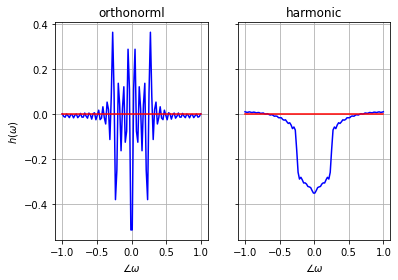

In [21]:
xx_test = np.linspace(-1, 1, 100)
Z_test = np.exp(1j * np.pi * xx_test)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(xx_test, np.real(clp_orth(Z_test)), c='b')
ax[0].plot(xx_test, np.imag(clp_orth(Z_test)), c='r')

ax[1].plot(xx_test, np.real(clp_harm(Z_test)), c='b')
ax[1].plot(xx_test, np.imag(clp_harm(Z_test)), c='r')

ax[0].set_title('orthonorml')
ax[1].set_title('harmonic')
ax[0].grid()
ax[1].grid()

ax[0].set_ylabel('$h(\omega)$')
ax[0].set_xlabel('$\\angle \omega$')
ax[1].set_xlabel('$\\angle \omega$')

<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)
<ipython-input-18-a738ea085e2e>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, d] = _x ** d / np.sqrt(gamma)


Text(0.5, 0, '$\\Re[h]$')

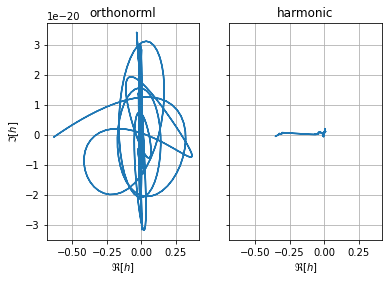

In [23]:
xx_test = np.linspace(-1, 1, 1000)
Z_test = np.exp(1j * np.pi * xx_test)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(np.real(clp_orth(Z_test)), np.imag(clp_orth(Z_test)))
ax[1].plot(np.real(clp_harm(Z_test)), np.imag(clp_harm(Z_test)))
ax[0].set_title('orthonorml')
ax[1].set_title('harmonic')
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel('$\Im[h]$')
ax[0].set_xlabel('$\Re[h]$')
ax[1].set_xlabel('$\Re[h]$')